**Thermal Waves**

January 11, 2022

In this tutorial we will interpolate between points provided in a thermistor calibration file and then use the interpolated data to convert a set of resistance measurements in ohms to temperature in celsius.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

The first step is to import the calibration data and the experimentally measured resistance readings.

Here's the calibration data

Resistance values: [ 2069.  2402.  2799.  3273.  3843.  4529.  5359.  6367.  7599.  9109.
 10970. 13280. 16150. 19740. 24270. 30000. 37300. 46670.]
Corresponding temperature values: [100.  95.  90.  85.  80.  75.  70.  65.  60.  55.  50.  45.  40.  35.
  30.  25.  20.  15.]


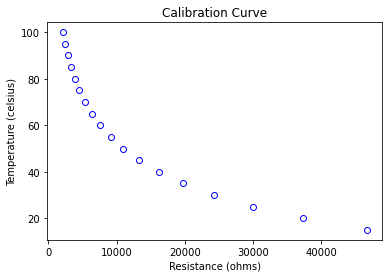

In [2]:
calData = np.loadtxt('thermister calibration data.dat')
Rcal = calData[:, 0]
Tcal = calData[:, 1]
plt.plot(Rcal, Tcal, 'bo', fillstyle = 'none')
plt.xlabel('Resistance (ohms)')
plt.ylabel('Temperature (celsius)')
plt.title('Calibration Curve')
print('Resistance values:', Rcal) # ohms
print('Corresponding temperature values:', Tcal) # Celcius

To do the interpolation, we will use the Python module 'SciPy' and the function 'interp1d()'.

To use interp1, you first must supply the x calibration data (Rcal) and the y calibration data (Tcal). 

In [3]:
from scipy.interpolate import interp1d 
f_lin_interp = interp1d(Rcal, Tcal);

'interp1d()' creates a function, which we called 'f_lin_interp' that we can now evaluate at any x (in our case resistance) value that is within the interpolation range.  The interpolation range will be the values of resistance that fall between the min and max values in Rcal.

In [4]:
Rval = 28e3 # ohms
Tval = f_lin_interp(Rval)
print('When R =', Rval, 'ohms the temperature is', Tval,'degrees Celcius.')

When R = 28000.0 ohms the temperature is 26.74520069808028 degrees Celcius.


We can use this function to plot a continuouse calibration curve.

Show the calibration data...

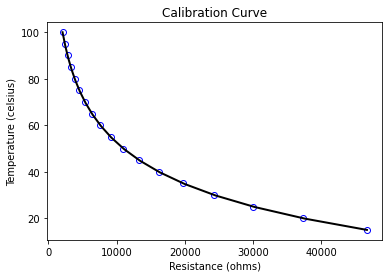

In [5]:
plt.plot(Rcal, Tcal, 'bo', fillstyle = 'none')
plt.xlabel('Resistance (ohms)')
plt.ylabel('Temperature (celsius)')
plt.title('Calibration Curve')

# and the interpolation.
xx = np.linspace(min(Rcal), max(Rcal), 5000)
plt.plot(xx, f_lin_interp(xx), 'k-', linewidth = 2);

The interpolation that we just did simply connects the space between the points with straight lines.  If we want to have the points joined by a smooth curve we can add the option 'kind = 'cubic'' to 'interp1d()'.  This time, I will also add the option 'fill_value = 'extrapolate'' which will allow use to estimate values of T outside of the interpolation range.

Show the calibration data...

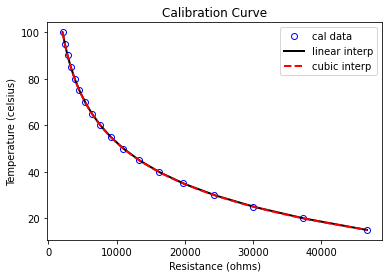

In [6]:
plt.plot(Rcal, Tcal, 'bo', fillstyle = 'none')
plt.xlabel('Resistance (ohms)')
plt.ylabel('Temperature (celsius)')
plt.title('Calibration Curve')

# and the first interpolation...
xx = np.linspace(min(Rcal), max(Rcal), 5000)
plt.plot(xx, f_lin_interp(xx), 'k-', linewidth = 2);

# and the second interpolation.
f_cubic_interp = interp1d(Rcal, Tcal, kind = 'cubic', fill_value = 'extrapolate')
plt.plot(xx, f_cubic_interp(xx), 'r--', linewidth = 2)
plt.legend(('cal data', 'linear interp', 'cubic interp'));

We'll show these curve together a second time while zoomed into a narrow range of R values.  This will highlight the difference between the linear and cuboc interpolations.

Show the calibration data...

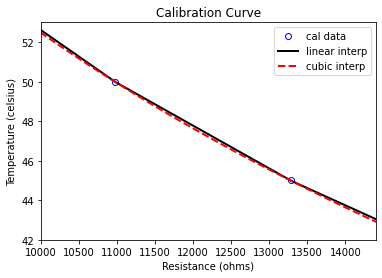

In [7]:
plt.plot(Rcal, Tcal, 'bo', fillstyle = 'none')
plt.xlabel('Resistance (ohms)')
plt.ylabel('Temperature (celsius)')
plt.title('Calibration Curve')

# and the first interpolation...
xx = np.linspace(min(Rcal), max(Rcal), 5000)
plt.plot(xx, f_lin_interp(xx), 'k-', linewidth = 2);

# and the second interpolation.
f_cubic_interp = interp1d(Rcal, Tcal, kind = 'cubic', fill_value = 'extrapolate')
plt.plot(xx, f_cubic_interp(xx), 'r--', linewidth = 2)
plt.legend(('cal data', 'linear interp', 'cubic interp'))
plt.axis((10000,  14400, 42, 53));

Here are the measured resistances from a PHYS 232 thermal waves experiment. 

The first column of data in the file is time in seconds.

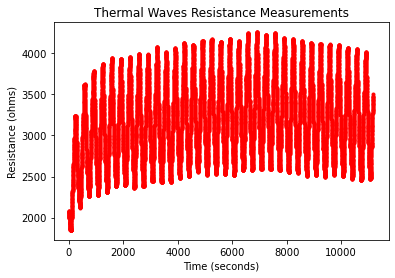

In [8]:
expData = np.loadtxt('thermalWaves-12092010-00-x05cm f003Hz V80V.dat')
time = expData[:, 0]
Rexp = expData[:, 1]
plt.plot(time, Rexp, 'r.')
plt.ylabel('Resistance (ohms)')
plt.xlabel('Time (seconds)')
plt.title('Thermal Waves Resistance Measurements');

Here's a plot of the data after using cubic interpolation function to convert the resistance measurements to temperatures.

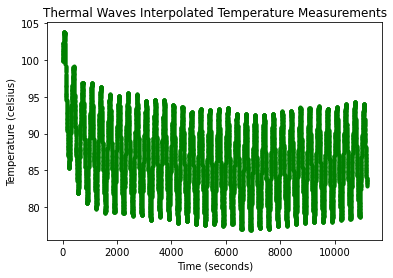

In [9]:
plt.plot(time, f_cubic_interp(Rexp), 'g.')
plt.ylabel('Temperature (celsius)')
plt.xlabel('Time (seconds)')
plt.title('Thermal Waves Interpolated Temperature Measurements');

In the thermal waves experiment, we're not interested in the average temperature of the copper rod.  We're really only interested in the temperature oscillations.  In the plot above we'd like to subtract off the average temperature.  However, the average temperature drifts with time.  Therefore, we will define a window of size N, determine the average temperature of within that window a subtract that value from the measured temperature at the centre of the window.  That window of N points will be used across the entire data set.  In the end, we will have data set centred on zero with N/2 fewer points at the beginning and end of the array. 

We will import the `pandas' module to help use with our *moving average*.

In [10]:
import pandas as pd

First, convert the measured resistances using the interpolation function defined above.  

Also, define the size of the average window.  I tried to make the averaging window correspond to approximately one period of the observed oscillations. 

In [11]:
T_data = f_cubic_interp(Rexp)
N = round(len(T_data)/33)

Here are some commands from the pandas modul to create the windows of size N and then find the mean values in each window.

In [12]:
numbers_series = pd.Series(T_data)
windows = numbers_series.rolling(N)
moving_averages = windows.mean()

Now put the calculated averages into a list that can be used to correct the temperature data.

In [13]:
moving_averages_list = moving_averages.tolist()
averages_list = moving_averages_list[N - 1:]

Finally...

- Remove N/2 points from the start and end of the temperature data
- Subtract the moving average from the temperature data
- Remove N/2 points from the start and end of the time data
- Plot the results

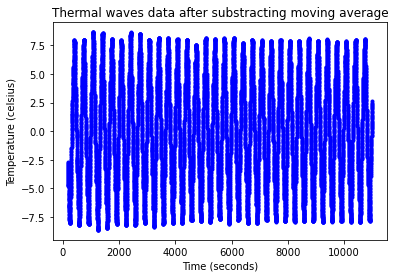

In [14]:
T_sub = T_data[round(N/2) - 1:len(T_data) - round(N/2) + 1]
T_corr = T_sub - averages_list
time_sub = time[round(N/2) - 1:len(time) - round(N/2) + 1]

plt.plot(time_sub, T_corr, 'b.')
plt.ylabel('Temperature (celsius)')
plt.xlabel('Time (seconds)')
plt.title('Thermal waves data after substracting moving average');

Let's export this corrected tempperature data for further processing.  For example, in the thermal waves analysis we will want to take the Fourier transform of this data and extract the amplitude of the fundamental Fourier component.

In [15]:
M = np.transpose(np.matrix([time_sub, T_corr]))
np.savetxt('Corrected thermal waves T vs t data.txt', M) 